In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pipe import select, where, sort
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, fbeta_score, make_scorer

sns.set_theme(style='whitegrid', context='paper')

In [4]:
# Read in column names from 'data/network-traffic/kddcup.names.dat'
import re

with open('data/network-traffic/kddcup.names.dat') as file:
    col_re = r'(\w+)\:.*'
    cols = [re.search(col_re, line)[1] for line in file.readlines()[1:]] + ['target']

cols[:5]

['duration', 'protocol_type', 'service', 'flag', 'src_bytes']

In [5]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.csv', names=cols, index_col=False, header=None).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', names=cols, index_col=False, header=None).drop_duplicates()
complete_df = pd.concat([training_df, testing_df], axis=0)

training_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal


--------------------------------------------------------------------------------

# Preprocessing

In [6]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1152283 entries, 0 to 310931
Data columns (total 42 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   duration                     1152283 non-null  int64  
 1   protocol_type                1152283 non-null  object 
 2   service                      1152283 non-null  object 
 3   flag                         1152283 non-null  object 
 4   src_bytes                    1152283 non-null  int64  
 5   dst_bytes                    1152283 non-null  int64  
 6   land                         1152283 non-null  int64  
 7   wrong_fragment               1152283 non-null  int64  
 8   urgent                       1152283 non-null  int64  
 9   hot                          1152283 non-null  int64  
 10  num_failed_logins            1152283 non-null  int64  
 11  logged_in                    1152283 non-null  int64  
 12  num_compromised              1152283 non-null  i

## Attack Classification

Instead of training a model to identify indivicual attack types on the spot, we will aim for finding
two models with two distinct tasks: the first is to find whether or not an attack is happening, the
second is to classify the attack into one of the four groups.

In [7]:
# Grouping of Attack Types
attack_group_mapping_ = {
    'neptune': 'dos',
    'satan': 'probe',
    'smurf': 'dos',
    'ipsweep': 'probe',
    'portsweep': 'probe',
    'nmap': 'probe',
    'guess_passwd': 'r2l',
    'back': 'dos',
    'mscan': 'probe',
    'warezmaster': 'r2l',
    'teardrop': 'dos',
    'warezclient': 'r2l',
    'apache2': 'dos',
    'processtable': 'dos',
    'saint': 'probe',
    'snmpguess': 'probe',
    'mailbomb': 'dos',
    'pod': 'dos',
    'snmpgetattack': 'dos',
    'httptunnel': 'r2l',
    'buffer_overflow': 'u2r',
    'land': 'dos',
    'multihop': 'r2l',
    'rootkit': 'u2r',
    'named': 'r2l',
    'ps': 'u2r',
    'sendmail': 'r2l',
    'imap': 'r2l',
    'xterm': 'r2l',
    'loadmodule': 'u2r',
    'ftp_write': 'r2l',
    'xlock': 'r2l',
    'phf': 'r2l',
    'perl': 'u2r',
    'xsnoop': 'r2l',
    'udpstorm': 'dos',
    'spy': 'r2l',
    'worm': 'r2l',
    'sqlattack': 'u2r'
}
print(f'{len(set(attack_group_mapping_.keys()))} attack types are going to be classified into {len(set(attack_group_mapping_.values()))} distinct groups.')
def is_attack(target):
    match target:
        case 'normal':
            return False
        case _:
            return True
def group_attack_type(a_type): return attack_group_mapping_[a_type] if is_attack(a_type) else a_type

39 attack types are going to be classified into 4 distinct groups.


In [8]:
# Add two columns to the data frames
complete_df['target_group'] = complete_df.target.map(group_attack_type)
training_df['target_group'] = training_df.target.map(group_attack_type)
testing_df['target_group'] = testing_df.target.map(group_attack_type)
complete_df['is_attack'] = complete_df.target.map(is_attack)
training_df['is_attack'] = training_df.target.map(is_attack)
testing_df['is_attack'] = testing_df.target.map(is_attack)

In [9]:
# Handle columns with `object`-type values
object_column_names = [complete_df[col].name for col in complete_df.columns if complete_df[col].dtype == 'object']
print(f'There are {len(object_column_names)} columns of type `object`: {object_column_names}.')

There are 5 columns of type `object`: ['protocol_type', 'service', 'flag', 'target', 'target_group'].


In [10]:
# Check out the 'protocol_type'
training_df.protocol_type.unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

In [11]:
# Check out the `service`
training_df.service.unique()

array(['http', 'smtp', 'domain_u', 'auth', 'finger', 'telnet', 'eco_i',
       'ftp', 'ntp_u', 'ecr_i', 'other', 'urp_i', 'private', 'pop_3',
       'ftp_data', 'netstat', 'daytime', 'ssh', 'echo', 'time', 'name',
       'whois', 'domain', 'mtp', 'gopher', 'remote_job', 'rje', 'ctf',
       'supdup', 'link', 'systat', 'discard', 'X11', 'shell', 'login',
       'imap4', 'nntp', 'uucp', 'pm_dump', 'IRC', 'Z39_50', 'netbios_dgm',
       'ldap', 'sunrpc', 'courier', 'exec', 'bgp', 'csnet_ns', 'http_443',
       'klogin', 'printer', 'netbios_ssn', 'pop_2', 'nnsp', 'efs',
       'hostnames', 'uucp_path', 'sql_net', 'vmnet', 'iso_tsap',
       'netbios_ns', 'kshell', 'urh_i', 'http_2784', 'harvest', 'aol',
       'tftp_u', 'http_8001', 'tim_i', 'red_i'], dtype=object)

In [12]:
# Check out the `flag`
training_df.flag.unique()

array(['SF', 'S2', 'S1', 'S3', 'OTH', 'REJ', 'RSTO', 'S0', 'RSTR',
       'RSTOS0', 'SH'], dtype=object)

In [13]:
# check out the `target`
training_df.target.unique()     # -> one-hot

array(['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune',
       'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep',
       'land', 'ftp_write', 'back', 'imap', 'satan', 'phf', 'nmap',
       'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'],
      dtype=object)

In [19]:
## Encoding using LabelEncoder (to align further research with Nilgün's notebook)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
complete_df_enc_le = complete_df.copy()
training_df_enc_le = training_df.copy()
testing_df_enc_le = testing_df.copy()
for column in object_column_names:
    complete_df_enc_le[column] = label_encoder.fit_transform(complete_df[column])
    training_df_enc_le[column] = label_encoder.transform(training_df[column])
    testing_df_enc_le[column] = label_encoder.transform(testing_df[column])

--------------------------------------------------------------------------------

# Metrics and Reduced Datasets for HPT

In [20]:
# Metrics
beta = 10
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

# Finding the best model
BEST_MODEL_IS_ATTACK = None
BEST_SCORE_IS_ATTACK = None
BEST_MODEL_ATTACK_GROUP = None
BEST_SCORE_ATTACK_GROUP = None

In [22]:
# Selecting subsets of the data according to their importance for the models

feature_imp_is_attack = {
    'same_srv_rate': 0.21199866684770505,
    'count': 0.1385794555921013,
    'diff_srv_rate': 0.11660354574720663,
    'src_bytes': 0.07133604504271888,
    'flag': 0.0689813541719748,
    'dst_host_srv_serror_rate': 0.0621598020912925,
    'dst_bytes': 0.057168688956664895,
    'dst_host_same_srv_rate': 0.05254858459557669,
    'srv_serror_rate': 0.04469331875735019,
    'serror_rate': 0.04097324469080398,
    'service': 0.01868051080047695,
    'dst_host_serror_rate': 0.01802081827734208,
    'dst_host_srv_count': 0.011545183650792126,
    'dst_host_same_src_port_rate': 0.011337335403034117,
    'protocol_type': 0.01111283067949643,
    'srv_count': 0.009167672319969513,
    'dst_host_count': 0.00873490361773566,
    'dst_host_srv_rerror_rate': 0.008354143406230159,
    'dst_host_diff_srv_rate': 0.007982036329319523,
    'logged_in': 0.007096409133012435,
    'dst_host_srv_diff_host_rate': 0.006912055417103559,
    'dst_host_rerror_rate': 0.0048513483664072345,
    'rerror_rate': 0.0025784179881967813,
    'wrong_fragment': 0.0020432908004560796,
    'srv_rerror_rate': 0.0016133665984154693,
    'num_compromised': 0.001456082442758954,
    'duration': 0.0013066127485688805,
    'hot': 0.0012589559107352938,
    'srv_diff_host_rate': 0.0006086465735149157,
    'is_guest_login': 0.00013464784144864953,
    'num_root': 4.6925733316063196e-05,
    'num_failed_logins': 4.487859382061017e-05,
    'num_file_creations': 2.0557845839487765e-05,
    'root_shell': 1.7416012225572053e-05,
    'num_access_files': 1.2171215578937403e-05,
    'num_shells': 8.344719212122783e-06,
    'urgent': 4.825536792287678e-06,
    'land': 4.449872331211087e-06,
    'su_attempted': 2.354686052141186e-06,
    'is_host_login': 1.0098642182210754e-07,
    'num_outbound_cmds': 0.0,
}
feature_imp_attack_group = {
    'count': 0.11920650442888907,
    'same_srv_rate': 0.10508972465410206,
    'diff_srv_rate': 0.08778113217680307,
    'serror_rate': 0.06974624054103938,
    'src_bytes': 0.0640681281401352,
    'dst_host_serror_rate': 0.06197018656697434,
    'dst_host_srv_serror_rate': 0.049256820180968386,
    'flag': 0.0491294984749818,
    'srv_serror_rate': 0.04423081413644857,
    'dst_host_srv_count': 0.03069288273419006,
    'dst_host_same_srv_rate': 0.020759103385937262,
    'dst_host_diff_srv_rate': 0.01598050573983522,
    'logged_in': 0.011148092661821485,
    'dst_host_same_src_port_rate': 0.010252432103140747,
    'dst_host_rerror_rate': 0.009870914010633081,
    'dst_bytes': 0.008271947585178354,
    'service': 0.007529789663669806,
    'dst_host_srv_diff_host_rate': 0.006014249598252015,
    'srv_count': 0.005338970005448468,
    'protocol_type': 0.004343821344787647,
    'dst_host_count': 0.003041925901452739,
    'dst_host_srv_rerror_rate': 0.0023676962473431987,
    'rerror_rate': 0.0022699746770110697,
    'srv_rerror_rate': 0.002078234928357929,
    'wrong_fragment': 0.0010900818924401603,
    'duration': 0.0007935300753938383,
    'srv_diff_host_rate': 0.0007000191956692632,
    'num_compromised': 0.0005603127418954962,
    'hot': 0.0005271824283889686,
    'is_guest_login': 0.00014356022382561943,
    'num_failed_logins': 3.086911390714573e-05,
    'num_root': 1.5834502309349034e-05,
    'root_shell': 1.3788709019323287e-05,
    'num_file_creations': 1.3195338230340304e-05,
    'land': 7.80724860591366e-06,
    'num_access_files': 4.715672181492601e-06,
    'num_shells': 2.8059963938124785e-06,
    'urgent': 1.687193322355405e-06,
    'su_attempted': 6.923677716956813e-07,
    'num_outbound_cmds': 0.0,
    'is_host_login': 0.0,
}
def feature(ranking): return ranking[0]
def importance(ranking): return ranking[1]
def top_n_features(n, features):
    return list(
        list(features.items())
        | sort(importance, reverse=True)
        | select(feature)
    )[:n]
def features_above(threshold, features):
    return list(
        list(features.items())
        | where(lambda feature: importance(feature) >= threshold)
        | select(feature)
    )

In [23]:
# For HPT, we will restrict ourselves to the top 15 respective most important features.
top_features_is_attack = top_n_features(15, feature_imp_is_attack)
top_features_attack_group = top_n_features(15, feature_imp_attack_group)

In [48]:
# Attack Detection
X_train_is_attack = training_df_enc_le[top_features_is_attack]
y_train_is_attack = training_df_enc_le.is_attack
X_test_is_attack = testing_df_enc_le[top_features_is_attack]
y_true_is_attack = testing_df_enc_le.is_attack

# Attack Classification
X_train_attack_group = training_df_enc_le[training_df_enc_le.is_attack][top_features_attack_group]
y_train_attack_group = training_df_enc_le[training_df_enc_le.is_attack].target_group
X_test_attack_group = testing_df_enc_le[testing_df_enc_le.is_attack][top_features_attack_group]
y_true_attack_group = testing_df_enc_le[testing_df_enc_le.is_attack].target_group

--------------------------------------------------------------------------------

# Random Forest Classification

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
rf_is_attack_model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=404
).fit(X_train_is_attack, y_train_is_attack)

rf_group_model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=404
).fit(X_train_attack_group, y_train_attack_group)

In [50]:
rf_is_attack_pred = rf_is_attack_model.predict(X_test_is_attack)
rf_attack_group_pred = rf_group_model.predict(X_test_attack_group)

In [51]:
print(f'{(rf_is_attack_accuracy := accuracy_score(y_true_is_attack, rf_is_attack_pred)) = }')
print(f'{(rf_is_attack_fbeta := fbeta_score(y_true_is_attack, rf_is_attack_pred, beta=beta, average=None)) = }\n')
print(classification_report(y_true_is_attack, rf_is_attack_pred))

(rf_is_attack_accuracy := accuracy_score(y_true_is_attack, rf_is_attack_pred)) = 0.9297330866465695
(rf_is_attack_fbeta := fbeta_score(y_true_is_attack, rf_is_attack_pred, beta=beta, average=None)) = array([0.99329947, 0.82578597])

              precision    recall  f1-score   support

       False       0.90      0.99      0.95     47913
        True       0.99      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.92     77291
weighted avg       0.94      0.93      0.93     77291



In [52]:
print(f'{(rf_attack_group_accuracy := accuracy_score(y_true_attack_group, rf_attack_group_pred)) = }')
print(f'{(rf_attack_group_fbeta := fbeta_score(y_true_attack_group, rf_attack_group_pred, beta=beta, average=None)) = }\n')
print(classification_report(y_true_attack_group, rf_attack_group_pred))

(rf_attack_group_accuracy := accuracy_score(y_true_attack_group, rf_attack_group_pred)) = 0.9072775546327183
(rf_attack_group_fbeta := fbeta_score(y_true_attack_group, rf_attack_group_pred, beta=beta, average=None)) = array([0.96321101, 0.82095444, 0.50242443, 0.14018043])

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23747
           2       0.60      0.82      0.69      3041
           3       0.91      0.50      0.64      2533
           4       0.12      0.14      0.13        57

    accuracy                           0.91     29378
   macro avg       0.65      0.61      0.61     29378
weighted avg       0.92      0.91      0.91     29378



## Hyperparameter Tuning

In [91]:
beta = 10
fbeta_average = 'weighted'
accuracy_scorer = make_scorer(accuracy_score)
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

def hyperparameter_tuning(parameter_grid, base_estimator, X_train, y_train, scoring, refit=True, verbose=3):
    return GridSearchCV(estimator=base_estimator, param_grid=parameter_grid, refit=refit, verbose=verbose, scoring=scoring).fit(X_train, y_train)

In [54]:
rf_param_grid = {
    'n_estimators': [20, 50, 100, 150],             # number of trees
    'max_depth': [5, 10, 20, 40, 60, None],         # maximum tree size (number of decisions)
    'criterion': ['gini', 'entropy', 'log_loss'],   # split criterion
    'n_jobs': [-1],                                 # number of parallel jobs; use all available cores
    'random_state': [404],                          # for reproducibility
}

In [ ]:
rf_is_attack_grid_search = hyperparameter_tuning(
    parameter_grid=rf_param_grid,
    base_estimator=RandomForestClassifier(),
    X_train=X_train_is_attack,
    y_train=y_train_is_attack,
    scoring=f10_scorer
)

In [ ]:
rf_attack_group_grid_search = hyperparameter_tuning(
    parameter_grid=rf_param_grid,
    base_estimator=RandomForestClassifier(),
    X_train=X_train_attack_group,
    y_train=y_train_attack_group,
    scoring=accuracy_scorer
)

In [106]:
from collections import namedtuple

hpt_result = namedtuple('HyperparameterTuningResult', ['model', 'best_params', 'best_score', 'accuracy', 'fbeta'])

def evaluate_hpt(model, X_test, y_true, beta=beta, average=fbeta_average):
    best_params = model.best_params_
    param_string = ''.join((f'\t{key}:\t{value}\n' for key, value in best_params.items()))
    best_score = model.best_score_
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('-- Training Results --')
    print(f'Best Parameters:\n{param_string}', end='')
    print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    return hpt_result(model, best_params, best_score, acc, fbeta)

In [93]:
rf_result_is_attack = evaluate_hpt(
    model=rf_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack
)

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	10
	n_estimators:	100
	n_jobs:	-1
	random_state:	404
Best Score:
	0.990874

-- Testing Results --
Accuracy    on Verification Data:	0.925606
Fbeta scroe on Verification Data:	0.925486

              precision    recall  f1-score   support

       False       0.90      0.99      0.94     47913
        True       0.99      0.81      0.89     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.90      0.92     77291
weighted avg       0.93      0.93      0.92     77291



In [61]:
from sklearn.metrics import confusion_matrix

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap='viridis')
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

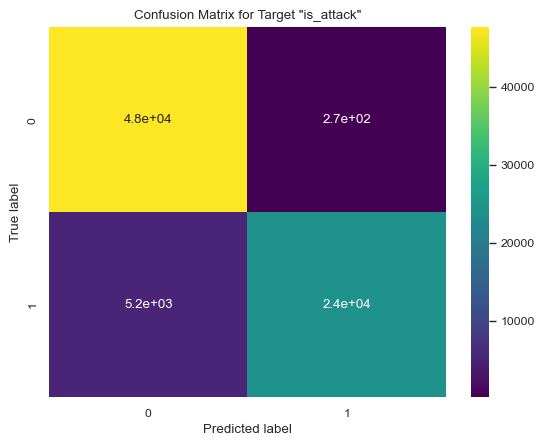

In [62]:
simple_confusion_matrix(y_true_is_attack, rf_is_attack_pred, 'is_attack')

In [94]:
rf_result_attack_group = evaluate_hpt(
    model=rf_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group
)

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	20
	n_estimators:	20
	n_jobs:	-1
	random_state:	404
Best Score:
	0.844451

-- Testing Results --
Accuracy    on Verification Data:	0.906767
Fbeta scroe on Verification Data:	0.906661

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23747
           2       0.62      0.82      0.70      3041
           3       0.82      0.50      0.62      2533
           4       0.14      0.16      0.15        57

    accuracy                           0.91     29378
   macro avg       0.64      0.61      0.61     29378
weighted avg       0.91      0.91      0.91     29378



In [102]:
def compare_models(new_results, old_results):
    is_improved = new_results.fbeta > old_results.fbeta
    print('-- HPT Evaluation --')
    print(f'{new_results.fbeta - old_results.fbeta = :.6f}', end='')
    print(' --> Improvement!') if is_improved else print(' --> Worsened!')
    print(f'{new_results.accuracy - old_results.accuracy = :.6f}', end='')
    print(' --> Improvement!') if new_results.accuracy > old_results.accuracy else print(' --> Worsened!')

    print(f'\nBest model so far:')
    best_results = new_results if is_improved else old_results
    best_model = f'{best_results.model.estimator} with Parameters\n{best_results.best_params}'
    best_score = new_results.fbeta if is_improved else old_results.fbeta
    print(f'{best_model}\nIts score: {best_score:.6f}')

    return best_model, best_score

In [105]:
BEST_MODEL_IS_ATTACK, BEST_SCORE_IS_ATTACK = compare_models(rf_result_is_attack, rf_result_is_attack)
print()
BEST_MODEL_ATTACK_GROUP, BEST_SCORE_ATTACK_GROUP = compare_models(rf_result_attack_group, rf_result_attack_group)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 404}
Its score: 0.925486

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 404}
Its score: 0.906661
